In [1]:
# %load_ext nb_black
# !pip install nb_black

import warnings

warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn import metrics as m
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE  # doctest: +NORMALIZE_WHITESPACE
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
import xgboost as xgb
from sklearn.pipeline import make_pipeline
from mlxtend.feature_selection import ColumnSelector
from sklearn import model_selection
from mlxtend.classifier import StackingClassifier
from thundersvm import SVC as svmgpu
import pickle


In [3]:
randomseed = 7
np.random.seed(randomseed)

# 1. Read the dataset

In [4]:
x_original = pd.read_csv("../../Dataset/XLable_onlyDiabeticRemoved.txt")

conditions = [
    (x_original.L100800 < 100),
    (x_original.L100800 >= 100) & (x_original.L100800 < 126),
    (x_original.L100800 >= 126),
]
choices = [0, 1, 2]
x_original["CLASS"] = np.select(conditions, choices, default=0)

x_original = x_original[
    ['AGE', 'FIELD_1', 'FIELD_15', 'FIELD_16', 'FIELD_17', 'FIELD_2',
       'FIELD_22', 'FIELD_23', 'FIELD_24', 'FIELD_31', 'FIELD_33',
       'FIELD_38', 'FIELD_40', 'L100500', 'L100700', 'L100800', 'L101200',
       'L101300', 'L101600', 'L101700', 'L103000', 'L103100', 'L103300',
       'L104600', 'L107400', 'L190000', 'L190300', 'L190400', 'L190500',
       'S000100', 'S000300', 'S000501', 'S000502', 'SEX', 'Unnamed: 0']
]

print(x_original.shape)

(185843, 35)


In [5]:
y_original = pd.read_csv("../../Dataset/TargetLable_onlyDiabeticRemoved.txt")

conditions = [
    (y_original.L100800 < 100),
    (y_original.L100800 >= 100) & (y_original.L100800 < 126),
    (y_original.L100800 >= 126),
]

choices = [0, 1, 2]
y_original["CLASS"] = np.select(conditions, choices, default=0)

y_original = y_original[["Unnamed: 0", "CLASS"]]

print(y_original.shape)

(185843, 2)


In [6]:
data = pd.merge(
    x_original, y_original, how="inner", left_on="Unnamed: 0", right_on="Unnamed: 0"
)

In [7]:
# filter the data set
data = data[data.FIELD_16 != 1]  # exclude people who are diagnosed for (diabetes)
data = data[data.FIELD_23 != 1]  # exclude people who are on medication for diabetes

data = data[
    data.FIELD_15 != 1
]  # exclude people who are diagnosed for (high blood pressure)
data = data[
    data.FIELD_22 != 1
]  # exclude people who are on medication for high blood pressure

data = data[data.FIELD_17 != 1]  # exclude people who are diagnosed for hyperlipidemia
data = data[
    data.FIELD_24 != 1
]  # exclude people who are on medication for hyperlipidemia

print(data.shape)

(169024, 36)


In [8]:
# data = data[
#     [
#         "L100800",
#         "L104600",
#         "L103000",
#         "S000300",
#         "L101700",
#         "L100700",
#         "FIELD_33",
#         "FIELD_38",
#         "FIELD_40",
#         "FIELD_31",
#         "SEX",
#         "AGE",
#         "CLASS",
#     ]
# ]
data = data.dropna()
print(data.shape)
data.head()

(48816, 36)


,AGE,FIELD_1,FIELD_15,FIELD_16,FIELD_17,FIELD_2,FIELD_22,FIELD_23,FIELD_24,FIELD_31,...,L190300,L190400,L190500,S000100,S000300,S000501,S000502,SEX,Unnamed: 0,CLASS
2,46.0,64,0.0,0.0,0.0,20150904,0.0,0.0,0.0,0.0,...,4.26,12.9,38.4,159.0,20.2,135.0,82.0,1.0,2,0
5,52.0,323,0.0,0.0,0.0,20150917,0.0,0.0,0.0,0.0,...,3.92,12.6,38.6,156.0,25.5,111.0,65.0,1.0,5,0
10,37.0,852,0.0,0.0,0.0,20150427,0.0,0.0,0.0,1.0,...,4.44,13.4,40.0,155.0,21.2,136.0,61.0,1.0,10,0
11,39.0,981,0.0,0.0,0.0,20160803,0.0,0.0,0.0,0.0,...,4.28,13.6,41.1,165.0,22.0,130.0,77.0,1.0,11,0
20,59.0,2113,0.0,0.0,0.0,20150311,0.0,0.0,0.0,0.0,...,4.67,14.1,41.3,155.0,24.6,111.0,67.0,1.0,20,0


In [15]:
# Load the trained regression models for the next year
with open('models/DiabeticModel_nextyear_L100800_RF_regressor',
          'rb') as f:
    reg_L100800 = pickle.load(f)

with open('models/DiabeticModel_nextyear_L104600_RF_regressor',
          'rb') as f:
    reg_L104600 = pickle.load(f)

with open('models/DiabeticModel_nextyear_L103000_RF_regressor',
          'rb') as f:
    reg_L103000 = pickle.load(f)

with open('models/DiabeticModel_nextyear_S000300_RF_regressor',
          'rb') as f:
    reg_S000300 = pickle.load(f)

with open('models/DiabeticModel_nextyear_L101700_RF_regressor',
          'rb') as f:
    reg_L101700 = pickle.load(f)

with open('models/DiabeticModel_nextyear_L100700_RF_regressor',
          'rb') as f:
    reg_L100700 = pickle.load(f)

In [16]:
#    features required to generate next year L104600 value
cols_L100800 = [
    'L100800', 'S000300', 'L103000', 'L104600', 'AGE', 'L100700',
    'L103100', 'L101700', 'L103300', 'L190500', 'L190400', 'L101300'
]

#    features required to generate next year L104600 value
cols_L104600 = [
    "L104600", "L100800", "S000300", "AGE", "L101300", "S000501",
    "L101700", "S000502", "L190000", "L101600", "L190300"
]

#    features required to generate next year L103000 value
cols_L103000 = [
    "L103000", "L100700", "L101700", "S000300", "S000502", "FIELD_33",
    "L190000", "L100800", "L101600", "S000501"
]

#    features required to generate next year S000300 value
cols_S000300 = [
    "S000300", "L103300", "S000501", "L100700", "SEX", "L103100",
    "L190300", "L190400", "L101300", "S000502"
]

#    features required to generate next year L101700 value
cols_L101700 = [
    "L101700", "L101300", "L103000", "SEX", "L100700", "L101200",
    "S000300", "S000501", "L100800", "S000502", "L101600", "S000100"
]

#    features required to generate next year L100700 value
cols_L100700 = ["L100700","L100500","S000100","S000300","L103300",
        "L103000","L103100","S000501","L101300","L101700","S000502","L107400",
]

In [17]:
N_y_L100800 = np.array(reg_L100800.predict(data[cols_L100800]))
N_y_L104600 = np.array(reg_L104600.predict(data[cols_L104600]))
N_y_L103000 = list(reg_L103000.predict(data[cols_L103000]))
N_y_S000300 = list(reg_S000300.predict(data[cols_S000300]))
N_y_L101700 = list(reg_L101700.predict(data[cols_L101700]))
N_y_L100700 = list(reg_L100700.predict(data[cols_L100700]))
N_y_SEX = list(data['SEX'])
N_y_AGE = list((data['AGE'].astype('int')) + 1)
N_y_FIELD_33 = list(data['FIELD_33'])
N_y_FIELD_38 = list(data['FIELD_38'])
N_y_FIELD_40 = list(data['FIELD_40'])
N_y_FIELD_31 = list(data['FIELD_31'])

In [25]:
np.unique(N_y_L100800)

array([ 75.50747951,  80.8375423 ,  81.99086505, ..., 273.15101378,
       274.93826428, 283.4238995 ])

In [29]:
tempdata=pd.DataFrame([N_y_L100800,N_y_L104600,N_y_L103000,N_y_S000300,N_y_L101700,N_y_L100700, N_y_SEX, N_y_AGE,
N_y_FIELD_33,N_y_FIELD_38,N_y_FIELD_40,N_y_FIELD_31,              
              ]).transpose()
tempdata.columns=['L100800_y', 'L104600_y', 'L103000_y', 'S000300_y', 'L101700_y', 'L100700_y', 'SEX_y', 'AGE_y',
                                 'FIELD_33_y', 'FIELD_38_y', 'FIELD_40_y', 'FIELD_31_y']
print(tempdata.shape)
tempdata.head()

(48816, 12)


,L100800_y,L104600_y,L103000_y,S000300_y,L101700_y,L100700_y,SEX_y,AGE_y,FIELD_33_y,FIELD_38_y,FIELD_40_y,FIELD_31_y
0,86.618660,5.256561,57.550228,20.507421,15.064708,3.909973,1.0,47.0,1.0,2.0,1.0,0.0
1,92.843062,5.603267,64.464275,25.506644,12.813293,3.725636,1.0,53.0,1.0,0.0,1.0,0.0
2,89.906903,5.658639,59.964402,21.455616,17.083690,4.047052,1.0,38.0,1.0,0.0,1.0,1.0
3,89.331473,4.956425,67.876510,21.912773,30.427081,4.383155,1.0,40.0,1.0,2.0,3.0,0.0
4,93.819919,5.578206,266.969211,24.618922,27.247033,4.788951,1.0,60.0,1.0,0.0,2.0,0.0


In [62]:
tempdata2=data[["L100800","L104600","L103000","S000300","L101700","L100700","FIELD_33",
                          "FIELD_38","FIELD_40","FIELD_31","SEX","AGE","CLASS"]]
tempdata2=pd.DataFrame(tempdata2.reset_index(drop=True))
tempdata2.shape

(48816, 13)

In [85]:
data=pd.concat([
    tempdata, tempdata2
    ]
    ,axis=1)

In [104]:
data.columns

Index(['L100800_y', 'L104600_y', 'L103000_y', 'S000300_y', 'L101700_y',
       'L100700_y', 'SEX_y', 'AGE_y', 'FIELD_33_y', 'FIELD_38_y', 'FIELD_40_y',
       'FIELD_31_y', 'L100800', 'L104600', 'L103000', 'S000300', 'L101700',
       'L100700', 'FIELD_33', 'FIELD_38', 'FIELD_40', 'FIELD_31', 'SEX', 'AGE',
       'CLASS'],
      dtype='object')

# 2. Downsample the majority class and upsample the minority

In [86]:
diabetic = data[data.CLASS == 2]
prediabetic = data[data.CLASS == 1]
normal = data[data.CLASS == 0]

print(diabetic.shape[0], prediabetic.shape[0], normal.shape[0])

890 14803 33123


In [87]:
import random

r = random.Random()
r.seed(42)
tempdatasize = 10000

# extremeDiabetesdata = prediabetic.sample(
#     tempdatasize, random_state=randomseed
# ).reset_index(drop=True)

extremeDiabetesdata = pd.concat([diabetic, diabetic, diabetic, diabetic])
# fpgnewadditionalvalues=r.sample(range(30, 200), tempdatasize)
# hbalcnewadditionalvalues=r.sample(range(1, 15), tempdatasize)

fpgnewadditionalvalues = []
hbalcnewadditionalvalues = []
extremeDiabetesdata.head()

,L100800_y,L104600_y,L103000_y,S000300_y,L101700_y,L100700_y,SEX_y,AGE_y,FIELD_33_y,FIELD_38_y,...,S000300,L101700,L100700,FIELD_33,FIELD_38,FIELD_40,FIELD_31,SEX,AGE,CLASS
1560,99.098682,5.278025,271.896650,22.156428,54.410741,6.713410,0.0,31.0,2.0,2.0,...,21.9,50.0,6.7,2.0,2.0,0.0,0.0,0.0,30.0,2
1688,216.705346,9.706181,1108.958395,31.293427,190.948083,7.724006,0.0,32.0,3.0,2.0,...,31.0,211.0,7.5,3.0,2.0,0.0,0.0,0.0,31.0,2
2057,203.361763,11.035698,110.927532,28.788534,29.626674,6.875013,0.0,32.0,1.0,2.0,...,28.7,27.0,7.1,1.0,2.0,5.0,1.0,0.0,31.0,2
2254,116.843656,5.755867,164.451959,29.202946,25.082110,6.603342,0.0,34.0,1.0,0.0,...,29.4,25.0,6.6,1.0,0.0,0.0,1.0,0.0,33.0,2
2573,120.968464,6.374726,294.633841,32.018535,56.657627,6.528172,0.0,33.0,1.0,1.0,...,31.9,56.0,6.4,1.0,1.0,1.0,0.0,0.0,32.0,2


In [88]:
for i in range(extremeDiabetesdata.shape[0]):
    fpgnewadditionalvalues.append(r.randint(30, 200))
    hbalcnewadditionalvalues.append(r.randint(10, 150) / 10)

    extremeDiabetesdata.iloc[i, 0] = (
        extremeDiabetesdata.iloc[i, 0] + fpgnewadditionalvalues[i]
    )

    extremeDiabetesdata.iloc[i, 1] = (
        extremeDiabetesdata.iloc[i, 1] + hbalcnewadditionalvalues[i]
    )

In [89]:
diabetic = pd.concat([diabetic, extremeDiabetesdata])

In [90]:
diabetic_test = diabetic.sample(200, random_state=randomseed)
prediabetic_test = prediabetic.sample(200, random_state=randomseed)
normal_test = normal.sample(200, random_state=randomseed)
test = pd.concat([diabetic_test, prediabetic_test, normal_test])

diabetic_train = diabetic.drop(diabetic_test.index)
prediabetic_train = prediabetic.drop(prediabetic_test.index)
# .sample(
#     10 * diabetic_train.shape[0], random_state=randomseed
# )
normal_train = normal.drop(normal_test.index).sample(
    prediabetic_train.shape[0],
    random_state=randomseed
    #     10 * diabetic_train.shape[0], random_state=randomseed
)
train = pd.concat([diabetic_train, diabetic_train, prediabetic_train, normal_train])

In [91]:
xtrain = train.iloc[:, :-1]
ytrain = train.iloc[:, -1]
xtest = test.iloc[:, :-1]
ytest = test.iloc[:, -1]

In [92]:
data.columns

Index(['L100800_y', 'L104600_y', 'L103000_y', 'S000300_y', 'L101700_y',
       'L100700_y', 'SEX_y', 'AGE_y', 'FIELD_33_y', 'FIELD_38_y', 'FIELD_40_y',
       'FIELD_31_y', 'L100800', 'L104600', 'L103000', 'S000300', 'L101700',
       'L100700', 'FIELD_33', 'FIELD_38', 'FIELD_40', 'FIELD_31', 'SEX', 'AGE',
       'CLASS'],
      dtype='object')

In [93]:
# from sklearn.preprocessing import MinMaxScaler

# scaler = MinMaxScaler()
# xtrain = scaler.fit_transform(xtrain)
# xtest = scaler.transform(xtest)

In [94]:
from imblearn.over_sampling import SMOTE, SMOTENC  # doctest: +NORMALIZE_WHITESPACE

randomseed = 42

sm = SMOTE(
    random_state=randomseed,
    sampling_strategy="minority",
)
X_res, y_res = sm.fit_resample(np.array(xtrain), np.array(ytrain))

print("Resampled dataset shape %s" % Counter(y_res))
print(
    y_res[y_res == 0].shape[0], y_res[y_res == 1].shape[0], y_res[y_res == 2].shape[0]
)
print(X_res.shape, y_res.shape)

xtrain = X_res
ytrain = y_res

Resampled dataset shape Counter({2: 14603, 1: 14603, 0: 14603})
14603 14603 14603
(43809, 24) (43809,)


# 3. Generate the classifier models based on the selected 12 features

# 3.1.  Features : 12

# a. Random forest

In [95]:
# from sklearn.model_selection import GridSearchCV
# from sklearn.ensemble import RandomForestClassifier

# parameters = {
#     "max_features": ("auto", "sqrt", "log2"),
#     "n_estimators": [10, 100, 200, 700],
#     "max_depth": [2, 8, 10],
#     "min_samples_split": [2, 8, 12],
#     "min_samples_leaf": [2, 8, 12],
#     "criterion": ["gini", "entropy"],
# }

# rf_clf = RandomForestClassifier(n_jobs=-1, verbose=1)
# rf_clf = GridSearchCV(rf_clf, parameters)
# rf_clf.fit(xtrain, ytrain)

In [96]:
# rf_clf.best_estimator_

In [97]:
rf_12 = RandomForestClassifier(
    random_state=randomseed,
    n_estimators=100,
    max_depth=12,
    min_samples_split=2,
    min_samples_leaf=10,
    max_features="auto",
)

# # rf_12=rf_clf.best_estimator_
# rf_12 = RandomForestClassifier(
#     bootstrap=True,
#     class_weight=None,
#     criterion="gini",
#     max_depth=10,
#     max_features="log2",
#     max_leaf_nodes=None,
#     min_impurity_decrease=0.0,
#     min_impurity_split=None,
#     min_samples_leaf=2,
#     min_samples_split=12,
#     min_weight_fraction_leaf=0.0,
#     n_estimators=100,
#     n_jobs=-1,
#     oob_score=False,
#     random_state=None,
#     verbose=1,
#     warm_start=False,
# )

In [98]:
rf_12.fit(xtrain, ytrain)

RandomForestClassifier(max_depth=12, min_samples_leaf=10, random_state=42)

In [99]:
ypred = rf_12.predict(xtest)
print("Accuracy = ", m.accuracy_score(ytest, ypred))

Accuracy =  0.7983333333333333


In [100]:
import pickle

pickle.dump(rf_12, open("_DiabeticClassifierModelForNextYear_rf_model_mf2", "wb"))

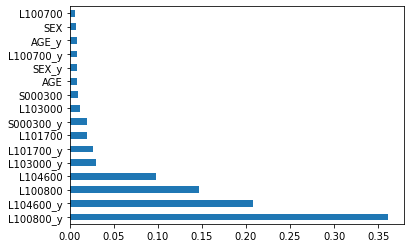

Index(['L100800_y', 'L104600_y', 'L100800', 'L104600', 'L103000_y',
       'L101700_y', 'L101700', 'S000300_y', 'L103000', 'S000300', 'AGE',
       'SEX_y', 'L100700_y', 'AGE_y', 'SEX', 'L100700'],
      dtype='object')
[0.36162473 0.2076337  0.14703193 0.0980387  0.0295954  0.02619367
 0.01999551 0.01934145 0.01216984 0.00928938 0.00879757 0.00854057
 0.00814017 0.00804941 0.00688651 0.00608924]


In [101]:
feat_importances = pd.Series(
    rf_12.feature_importances_, index=data.iloc[:, :-1].columns
)
feat_importances.nlargest(16).plot(kind="barh")
plt.show()

print(feat_importances.nlargest(16).index)
print(feat_importances.nlargest(16).values)

In [102]:
confmatrx = pd.DataFrame(
    m.confusion_matrix(ytest, ypred),
    columns=["Normal", "Prediabetes", "diabetes"],
    index=["Normal", "Prediabetes", "diabetes"],
)
confmatrx.head()

,Normal,Prediabetes,diabetes
Normal,148,52,0
Prediabetes,49,146,5
diabetes,0,15,185


In [103]:
print(m.classification_report(ytest, ypred))

              precision    recall  f1-score   support

           0       0.75      0.74      0.75       200
           1       0.69      0.73      0.71       200
           2       0.97      0.93      0.95       200

    accuracy                           0.80       600
   macro avg       0.80      0.80      0.80       600
weighted avg       0.80      0.80      0.80       600



In [24]:
from sklearn import model_selection

scores = model_selection.cross_val_score(
    rf_12, xtrain, ytrain, cv=10, scoring="accuracy"
)
print(
    "Accuracy: %0.2f (+/- %0.2f) [%s] \n [%s]"
    % (scores.mean(), scores.std(), "RandomForestClassifier", scores)
)

Accuracy: 0.77 (+/- 0.06) [RandomForestClassifier] 
 [[0.61964981 0.7729572  0.73501946 0.8096906  0.81222028 0.80618797
 0.80404748 0.78770189 0.79042615 0.77408056]]


<IPython.core.display.Javascript object>

# b. XGBOOST 

In [20]:
# parameters = {
#     "max_depth": [2, 8, 10],
#     "n_estimators": [10, 100, 700],
#     "learning_rate": [0.05, 0.15, 0.25],
#     "min_child_weight": [1, 3, 5],
#     "gamma": [0.0, 0.2, 0.4],
#     "colsample_bytree": [0.3, 0.4, 0.5],
# }
# xgb_clf = xgb.XGBClassifier()
# xgb_clf = RandomizedSearchCV(xgb_clf, parameters, verbose=2)
# xgb_clf.fit(xtrain, ytrain)
# xgb_clf.best_estimator_

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] n_estimators=100, min_child_weight=5, max_depth=8, learning_rate=0.05, gamma=0.2, colsample_bytree=0.4 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_estimators=100, min_child_weight=5, max_depth=8, learning_rate=0.05, gamma=0.2, colsample_bytree=0.4, total=   6.6s
[CV] n_estimators=100, min_child_weight=5, max_depth=8, learning_rate=0.05, gamma=0.2, colsample_bytree=0.4 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.5s remaining:    0.0s


[CV]  n_estimators=100, min_child_weight=5, max_depth=8, learning_rate=0.05, gamma=0.2, colsample_bytree=0.4, total=   6.5s
[CV] n_estimators=100, min_child_weight=5, max_depth=8, learning_rate=0.05, gamma=0.2, colsample_bytree=0.4 
[CV]  n_estimators=100, min_child_weight=5, max_depth=8, learning_rate=0.05, gamma=0.2, colsample_bytree=0.4, total=   6.3s
[CV] n_estimators=700, min_child_weight=3, max_depth=10, learning_rate=0.25, gamma=0.0, colsample_bytree=0.3 
[CV]  n_estimators=700, min_child_weight=3, max_depth=10, learning_rate=0.25, gamma=0.0, colsample_bytree=0.3, total=  43.8s
[CV] n_estimators=700, min_child_weight=3, max_depth=10, learning_rate=0.25, gamma=0.0, colsample_bytree=0.3 
[CV]  n_estimators=700, min_child_weight=3, max_depth=10, learning_rate=0.25, gamma=0.0, colsample_bytree=0.3, total=  43.1s
[CV] n_estimators=700, min_child_weight=3, max_depth=10, learning_rate=0.25, gamma=0.0, colsample_bytree=0.3 
[CV]  n_estimators=700, min_child_weight=3, max_depth=10, learn

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed: 11.3min finished


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.3, gamma=0.4,
              learning_rate=0.05, max_delta_step=0, max_depth=8,
              min_child_weight=5, missing=None, n_estimators=700, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

<IPython.core.display.Javascript object>

In [24]:
import xgboost as xgb
from sklearn import metrics as m

xgb_model_12 = xgb.XGBClassifier(objective="binary:logistic", random_state=randomseed)
# objective="multi:softmax"
# objective="binary:logistic"
# xgb_model=xgb_clf.best_estimator_

# xgb_model=xgb_clf.best_estimator_
# xgb_model_12=xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
#               colsample_bynode=1, colsample_bytree=0.3, gamma=0.2,
#               learning_rate=0.05, max_delta_step=0, max_depth=10,
#               min_child_weight=5, missing=None, n_estimators=700, n_jobs=1,
#               nthread=None, objective='multi:softprob', random_state=0,
#               reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
#               silent=None, subsample=1, verbosity=1)


<IPython.core.display.Javascript object>

In [25]:
xgb_model_12.fit(xtrain, ytrain)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=42, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

<IPython.core.display.Javascript object>

In [26]:
ypred = xgb_model_12.predict(xtest)
print("Accuracy = ", m.accuracy_score(ytest, ypred))

Accuracy =  0.7916666666666666


<IPython.core.display.Javascript object>

In [27]:
confmatrx = pd.DataFrame(
    m.confusion_matrix(ytest, ypred),
    columns=["Normal", "Prediabetes", "diabetes"],
    index=["Normal", "Prediabetes", "diabetes"],
)
confmatrx.head()

,Normal,Prediabetes,diabetes
Normal,152,48,0
Prediabetes,56,143,1
diabetes,0,20,180


<IPython.core.display.Javascript object>

In [28]:
print(m.classification_report(ytest, ypred))

              precision    recall  f1-score   support

           0       0.73      0.76      0.75       200
           1       0.68      0.71      0.70       200
           2       0.99      0.90      0.94       200

    accuracy                           0.79       600
   macro avg       0.80      0.79      0.80       600
weighted avg       0.80      0.79      0.80       600



<IPython.core.display.Javascript object>

In [29]:
scores = model_selection.cross_val_score(
    xgb_model_12, xtrain, ytrain, cv=10, scoring="accuracy"
)
print(
    "Accuracy: %0.2f (+/- %0.2f) [%s] \n [%s]"
    % (scores.mean(), scores.std(), "xgb_model", scores)
)

Accuracy: 0.76 (+/- 0.05) [xgb_model] 
 [[0.64494163 0.74046693 0.73871595 0.79256665 0.79587468 0.79723682
 0.77466433 0.76902121 0.80832847 0.78244795]]


<IPython.core.display.Javascript object>

# c. SVM

In [30]:
# from thundersvm import SVC as svmgpu

# parameters = {
#     "C": [0.1, 1, 10, 100, 1000],
#     "gamma": [1, 0.1, 0.01, 0.001, 0.0001],
#     "kernel": ["linear", "rbf"],
# }

# SVC_clf = svmgpu()
# SVC_clf2 = RandomizedSearchCV(SVC_clf, parameters, verbose=2)
# SVC_clf2.fit(xtrain, ytrain)


# # sorted(SVC_clf2.cv_results_.keys())

<IPython.core.display.Javascript object>

In [27]:
# SVC_clf2.best_estimator_

SVC(C=100, cache_size=None, class_weight={}, coef0=0.0,
    decision_function_shape='ovo', degree=3, gamma=0.1, gpu_id=0,
    kernel='linear', max_iter=-1, max_mem_size=-1, n_jobs=-1, probability=False,
    random_state=None, shrinking=False, tol=0.001, verbose=False)

<IPython.core.display.Javascript object>

In [31]:
# scv_12=SVC_clf2.best_estimator_
scv_12 = svmgpu(
    C=100,
    cache_size=None,
    class_weight={},
    coef0=0.0,
    decision_function_shape="ovo",
    degree=3,
    gamma=0.1,
    gpu_id=0,
    kernel="linear",
    max_iter=-1,
    max_mem_size=-1,
    n_jobs=-1,
    probability=False,
    random_state=None,
    shrinking=False,
    tol=0.001,
    verbose=False,
)

<IPython.core.display.Javascript object>

In [36]:
scv_12 = SVC(
    C=70,
    cache_size=200,
    class_weight=None,
    coef0=0.0,
    decision_function_shape="ovr",
    degree=3,
    #     gamma="auto_deprecated",
    kernel="linear",
    max_iter=-1,
    probability=True,
    random_state=42,
    shrinking=True,
    tol=0.001,
    verbose=False,
)

<IPython.core.display.Javascript object>

In [ ]:
scv_12.fit(xtrain, ytrain)

In [ ]:
ypred = scv_12.predict(xtest)
print("Accuracy = ", m.accuracy_score(ytest, ypred))

In [ ]:
confmatrx = pd.DataFrame(
    m.confusion_matrix(ytest, ypred),
    columns=["Normal", "Prediabetes", "diabetes"],
    index=["Normal", "Prediabetes", "diabetes"],
)
confmatrx.head()

In [ ]:
print(m.classification_report(ytest, ypred))

In [ ]:
scores = model_selection.cross_val_score(
    scv_12, xtrain, ytrain, cv=10, scoring="accuracy"
)
print(
    "Accuracy: %0.2f (+/- %0.2f) [%s] \n [%s]"
    % (scores.mean(), scores.std(), "SVC_clf", scores)
)